# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
!pip install wordcloud
!pip install gTTS
!pip install playsound

In [2]:
#Import all the required libraries
import glob
from skimage import io
from PIL import Image
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import time
import string
from wordcloud import WordCloud, STOPWORDS
import random 
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import nltk
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input

from gtts import gTTS
from playsound import playsound
from IPython import display

[nltk_data] Downloading package stopwords to /home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
playsound is relying on another python subprocess. Please use `pip install pygobject` if you want playsound to run more efficiently.


In [3]:
data_dir = 'data'
images_dir = os.path.join(data_dir, 'Images')
captions_file = os.path.join(data_dir, 'captions.txt')
output_image_path = '../working/image/'

Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create a dataframe which summarizes the image, path & captions as a dataframe

4.Create a list which contains all the captions & path

5.Visualise the top 30 occuring words in the captions



In [4]:
#Import the dataset and read the image into a seperate variable

all_imgs = glob.glob(images_dir + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


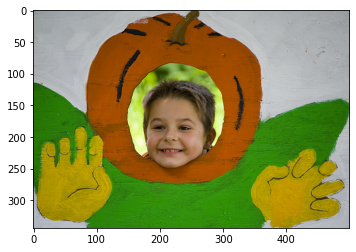

In [5]:
#Visualise both the images & text present in the dataset
plt.imshow(mpimg.imread(all_imgs[50]))
plt.show()

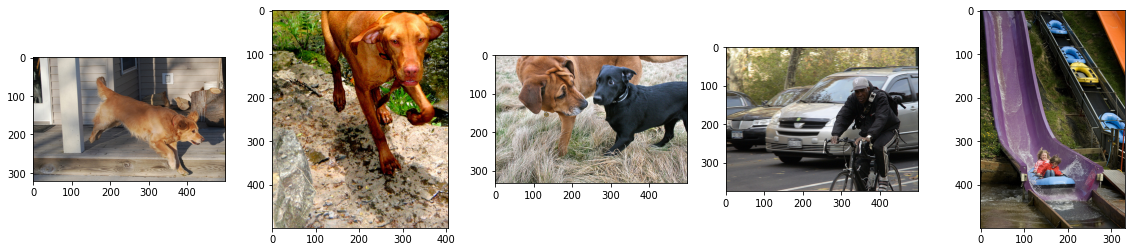

In [6]:
#Visualising first 5 images:

Display_Images= all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
   
for ax,image in zip(axes, Display_Images):
    ax.imshow(io.imread(image), cmap=None)

In [7]:
all_imgs[200:211]

['data/Images/1453366750_6e8cf601bf.jpg',
 'data/Images/2871962580_b85ce502ba.jpg',
 'data/Images/3094317837_b31cbf969e.jpg',
 'data/Images/1764955991_5e53a28c87.jpg',
 'data/Images/3429351222_17ae744daf.jpg',
 'data/Images/2643263887_a32ffb878f.jpg',
 'data/Images/3204686006_88f04547b9.jpg',
 'data/Images/1056338697_4f7d7ce270.jpg',
 'data/Images/369360998_ba56fb436f.jpg',
 'data/Images/2641770481_c98465ff35.jpg',
 'data/Images/2737233999_34d60dc5c3.jpg']

In [8]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    
    with open(filename,'r') as f:
        text =  list(filter(None, (line.rstrip() for line in f)))
    f.close()

    col = [line.split(",",maxsplit=1) for line in text]
    return text

text_file = data_dir +'/captions.txt'
doc = load_doc(text_file)
print(doc[1:4])

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .', '1000268201_693b08cb0e.jpg,A girl going into a wooden building .', '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .']


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [9]:
all_img_id=[i.split(',')[0] for i in doc[1:]] #store all the image id here
all_img_vector= [os.path.join(images_dir,i.split(',')[0]) for i in doc[1:]] #store all the image path here
annotations= [i.split(',')[1] for i in doc[1:]]#store all the captions here

df = pd.DataFrame(zip(all_img_id, all_img_vector,annotations),columns =['ID','Path', 'Captions']) 
    
df.head(10)

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,data/Images/1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
6,1001773457_577c3a7d70.jpg,data/Images/1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...
7,1001773457_577c3a7d70.jpg,data/Images/1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...
8,1001773457_577c3a7d70.jpg,data/Images/1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...
9,1001773457_577c3a7d70.jpg,data/Images/1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [10]:
# df['Path'][:10]
df.to_csv('df.csv', index=False)

In [11]:
df.info

<bound method DataFrame.info of                               ID                                   Path  \
0      1000268201_693b08cb0e.jpg  data/Images/1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg  data/Images/1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg  data/Images/1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg  data/Images/1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg  data/Images/1000268201_693b08cb0e.jpg   
...                          ...                                    ...   
40450   997722733_0cb5439472.jpg   data/Images/997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   data/Images/997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   data/Images/997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   data/Images/997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   data/Images/997722733_0cb5439472.jpg   

                                                Captions  
0      A

In [12]:
df = pd.read_csv('df.csv')
df

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,data/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
...,...,...,...
40450,997722733_0cb5439472.jpg,data/Images/997722733_0cb5439472.jpg,A man in a pink shirt climbs a rock face
40451,997722733_0cb5439472.jpg,data/Images/997722733_0cb5439472.jpg,A man is rock climbing high in the air .
40452,997722733_0cb5439472.jpg,data/Images/997722733_0cb5439472.jpg,A person in a red shirt climbing up a rock fac...
40453,997722733_0cb5439472.jpg,data/Images/997722733_0cb5439472.jpg,A rock climber in a red shirt .


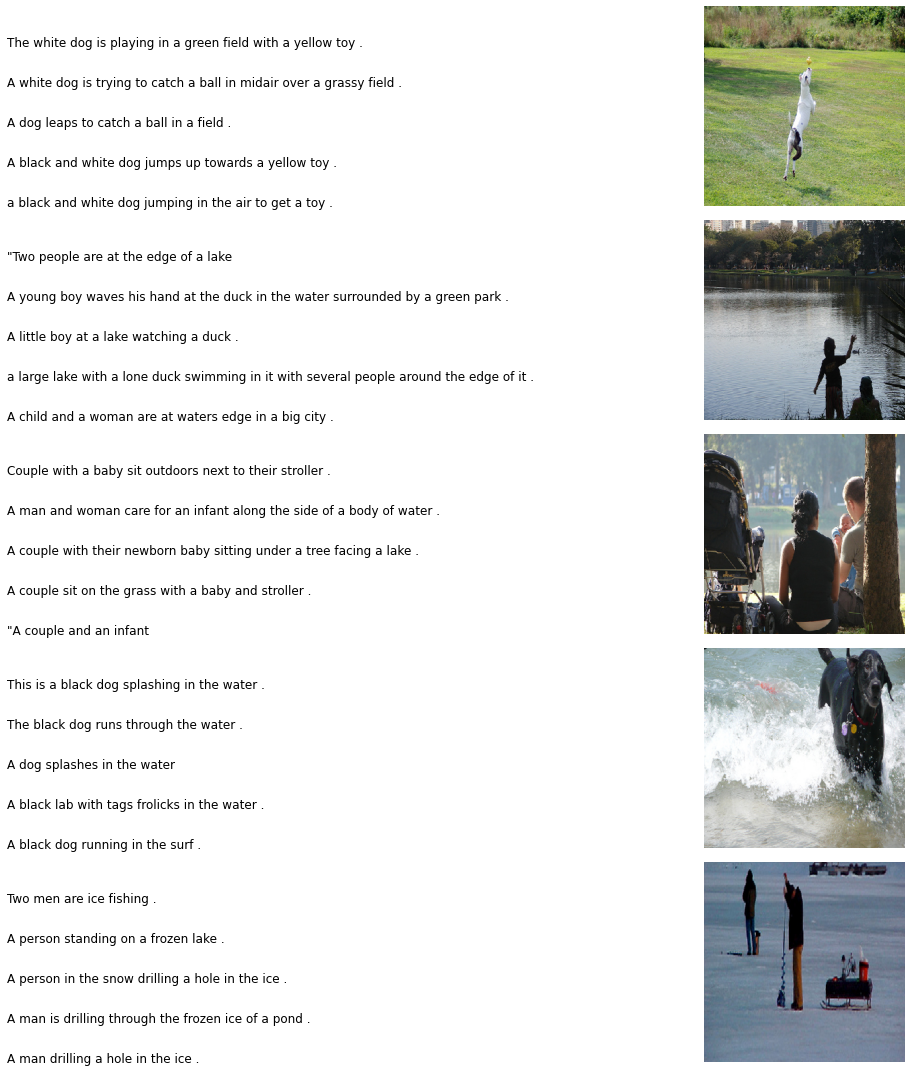

In [13]:
# Images 

fig = plt.figure(figsize=(15,15)) # For dosplaying image
count = 1
    
for Path in df[75:100].Path.unique(): # Loading 1st 25 paths which will have 5 distinct images
    captions = list(df["Captions"].loc[df.Path== Path].values)
    display_image = load_img(Path,target_size=(299,299,3))
    ax = fig.add_subplot(5,2,count) #Adding a subplot that spans 5 rows:
    plt.axis('off')  # we don't want both x and y axes for caption 
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions)) #to decide the spacing between each line of caption
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=12)  #to display the captions         
    count+=1
    plt.tight_layout() #to make sure that image and caption don't overlap

    ax = fig.add_subplot(5,2,count)
    ax.imshow(display_image)
    plt.axis('off')
    count +=1

plt.show()

In [14]:
# Data cleaning
# prepare translation table for removing punctuation
remove_punctuation = str.maketrans('', '', string.punctuation)
for i in range(len(annotations)):
    line = annotations[i]
    line = line.split()
    line = [word.lower() for word in line] # convert to lower case
    line = [word.translate(remove_punctuation) for word in line]# remove punctuation from each token
    line = [word for word in line if len(word)>1] # remove hanging 's' and 'a'
    line = [word for word in line if word.isalpha()]# remove tokens with numbers in them
    annotations[i]=  ' '.join(line)   # store as string
    

In [15]:
#Create a list which contains all the captions
annotations= ["<start> " + caption + " <end>" for caption in df['Captions']]
#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path=df.Path.to_list()

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


In [16]:
#Create the vocabulary & the counter for the captions

vocabulary = [word for caption in df.Captions.values for word in caption.split()]

val_count=Counter(vocabulary)


In [17]:
print(f'Size of Vocab:{len(set(vocabulary))}')
print(f'Top 10 in Vocab:{vocabulary[:10]}')
print(f'Top Words:{val_count.most_common(30)}')

Size of Vocab:9536
Top 10 in Vocab:['A', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a']
Top Words:[('a', 38716), ('.', 34205), ('A', 21480), ('in', 18170), ('the', 14587), ('on', 10354), ('is', 9069), ('and', 8057), ('dog', 7804), ('with', 7303), ('man', 6727), ('of', 6495), ('Two', 3962), ('white', 3646), ('black', 3491), ('boy', 3395), ('are', 3364), ('girl', 3174), ('woman', 3146), ('to', 3005), ('The', 2919), ('wearing', 2916), ('at', 2809), ('water', 2671), ('red', 2542), ('young', 2411), ('people', 2397), ('brown', 2383), ('his', 2255), ('blue', 2116)]


In [18]:
#Visualise the top 30 occuring words in the captions

#write your code here
for word, count in val_count.most_common(30):
    print(word, ": ", count)

a :  38716
. :  34205
A :  21480
in :  18170
the :  14587
on :  10354
is :  9069
and :  8057
dog :  7804
with :  7303
man :  6727
of :  6495
Two :  3962
white :  3646
black :  3491
boy :  3395
are :  3364
girl :  3174
woman :  3146
to :  3005
The :  2919
wearing :  2916
at :  2809
water :  2671
red :  2542
young :  2411
people :  2397
brown :  2383
his :  2255
blue :  2116


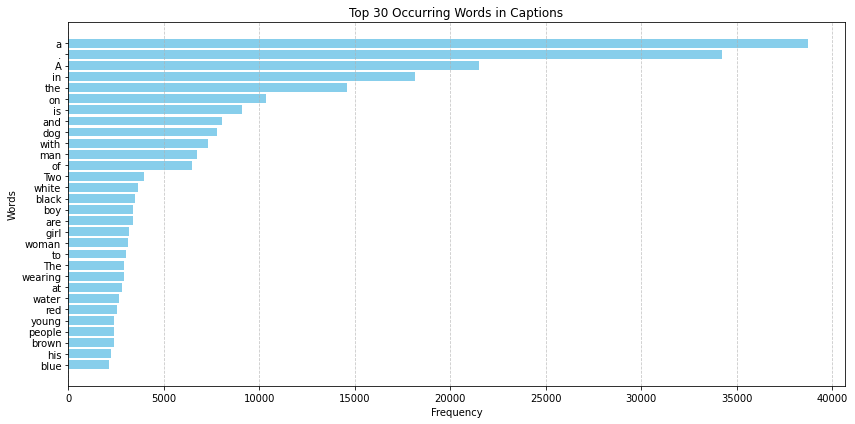

In [19]:
def plot_top_words(word_counter):
    plt.figure(figsize=(12, 6))
    plt.barh(*zip(*word_counter.most_common(30)), color='skyblue')
    plt.xlabel('Frequency')
    plt.ylabel('Words')
    plt.title('Top 30 Occurring Words in Captions')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()  # Adjust layout to prevent clipping labels
    plt.show()

plot_top_words(val_count)

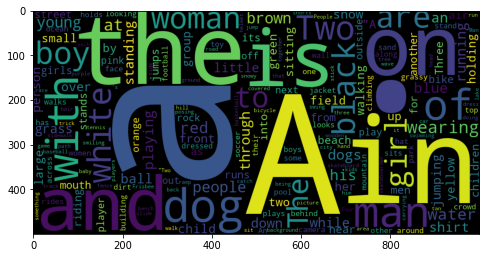

In [20]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

> Since most of the top words are stop words, which is obvious, we cannot clearly see what are the actual top words.
> Lets find out otp 30 words without the stop words.

In [21]:
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        print(word, ": ", count)

dict_without_stopwords = {}
for word, count in val_count.most_common(47):
    if word not in STOPWORDS:
        dict_without_stopwords[word] = count

. :  34205
A :  21480
dog :  7804
man :  6727
Two :  3962
white :  3646
black :  3491
boy :  3395
girl :  3174
woman :  3146
The :  2919
wearing :  2916
water :  2671
red :  2542
young :  2411
people :  2397
brown :  2383
blue :  2116
dogs :  2055
running :  1995
playing :  1954
shirt :  1735
standing :  1702
ball :  1678
little :  1607
grass :  1565
child :  1449
snow :  1431
jumping :  1429
person :  1393


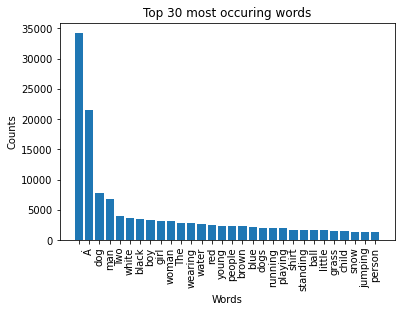

In [22]:
plt.bar(range(len(dict_without_stopwords)), dict_without_stopwords.values(), align='center');
plt.xticks(range(len(dict_without_stopwords)), list(dict_without_stopwords.keys()));
plt.title("Top 30 most occuring words");
plt.xlabel("Words");
plt.ylabel("Counts");
plt.xticks(rotation=90);

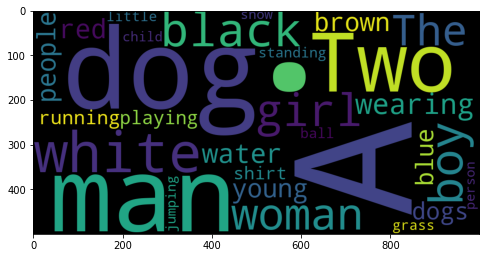

In [23]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(dict_without_stopwords)
plt.figure(figsize=(8,8))
plt.imshow(wordcloud)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [24]:
annotations[:5]

['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

In [25]:
# create the tokenizer

top_word_count = 5000

filter_chars = '!"#$%&()*+.,-/:;=?@[\]^_`{|}~ '
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_count,
                                                  oov_token="<unk>",
                                                  filters=filter_chars)
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)
print(train_seqs[:5])
print(annotations[:5])
print(f'OOV Token: {tokenizer.oov_token}')

[[3, 2, 44, 5, 2, 89, 173, 8, 116, 52, 2, 389, 13, 385, 5, 29, 1, 670, 4], [3, 2, 20, 313, 64, 2, 197, 120, 4], [3, 2, 39, 20, 116, 64, 2, 197, 2368, 4], [3, 2, 39, 20, 116, 6, 385, 21, 63, 2368, 4], [3, 2, 39, 20, 5, 2, 89, 173, 313, 64, 2, 197, 2887, 4]]
['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>', '<start> A girl going into a wooden building . <end>', '<start> A little girl climbing into a wooden playhouse . <end>', '<start> A little girl climbing the stairs to her playhouse . <end>', '<start> A little girl in a pink dress going into a wooden cabin . <end>']
OOV Token: <unk>


In [26]:
list(tokenizer.word_counts.items())[:20]

[('<start>', 40455),
 ('a', 61436),
 ('child', 1517),
 ('in', 18193),
 ('pink', 706),
 ('dress', 332),
 ('is', 9069),
 ('climbing', 495),
 ('up', 1251),
 ('set', 106),
 ('of', 6504),
 ('stairs', 109),
 ('an', 2358),
 ('entry', 1),
 ('way', 51),
 ('<end>', 40455),
 ('girl', 3284),
 ('going', 145),
 ('into', 1046),
 ('wooden', 278)]

In [27]:
# Create word-to-index and index-to-word mappings.

word_index = tokenizer.word_index
index_word = tokenizer.index_word

# Add Pad Token
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [28]:
## Save Tokenizer
import pickle

with open('./checkpoints/tokenizer.pkl',"wb") as f:
    pickle.dump(tokenizer,f)

In [29]:
# Print sample mappings
print("Sample word-to-index:", word_index['<start>'], word_index['dog'])
print("Sample index-to-word:", index_word[1], index_word[5])

Sample word-to-index: 3 10
Sample index-to-word: <unk> in


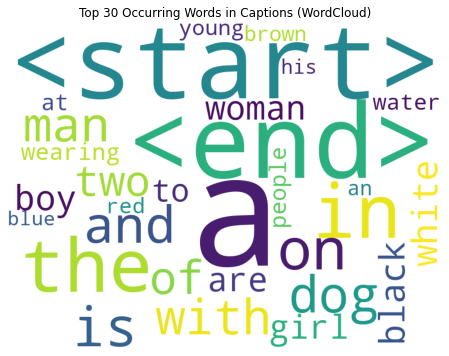

In [30]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
word_counts = tokenizer.word_counts  # Access word counts from the tokenizer
top_30_words = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:30])
top_30_words = {word: count for word, count in top_30_words.items() if word not in ('start', 'end')}


wordcloud = WordCloud(background_color='white', width=800, height=600).generate_from_frequencies(top_30_words)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("Top 30 Occurring Words in Captions (WordCloud)")
plt.show()

In [31]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

max_sequence_len = max(len(t) for t in train_seqs)
print(f'Max Sequence Length of the Texts is: {max_sequence_len}')

cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post', maxlen=max_sequence_len)
print("The shape of Caption vector is :" + str(cap_vector.shape))

Max Sequence Length of the Texts is: 35
The shape of Caption vector is :(40455, 35)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

### FAQs on how to resize the images::
* Since you have a list which contains all the image path, you need to first convert them to a dataset using <i>tf.data.Dataset.from_tensor_slices</i>. Once you have created a dataset consisting of image paths, you need to apply a function to the dataset which will apply the necessary preprocessing to each image. 
* This function should resize them and also should do the necessary preprocessing that it is in correct format for InceptionV3.


<hr>

In [32]:
#Trial before rprocessing all images

In [33]:
#Let's see how preprocessed image looks by preprocessing first 5 images alone.
preprocessed_img=[]
for img in all_imgs[50:55]:
    img = tf.io.read_file(img,name=None)
    # by default channels=0 which indictaes to use the number of channels in the JPEG-encoded image.
    img = tf.image.decode_jpeg(img,channels=0) #Since its RGB images,we can give channels=3 also which will output an RGB image.
    img = tf.image.resize(img, (299,299))
    img = tf.keras.applications.inception_v3.preprocess_input(img,data_format=None)#Default value for data format is None
    # It refers to global setting tf.keras.backend.image_data_format()
    preprocessed_img.append(img)

2024-02-28 17:57:16.433515: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-02-28 17:57:16.433590: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)
Shape after resize : (299, 299, 3)


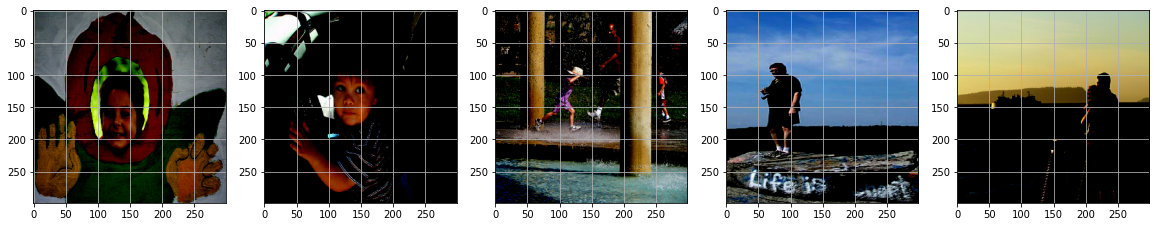

In [34]:
Display_Images= preprocessed_img[:5]
figure, axes = plt.subplots(1,5);
figure.set_figwidth(20);
   
for ax,image in zip(axes, Display_Images):
    print("Shape after resize :", image.shape)
    ax.imshow(image);
    ax.grid('off');

<hr>

In [35]:
#write your code here to create the dataset consisting of image paths
unique_img_vector = sorted (set(all_img_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_img_vector)

In [36]:
#write your code here for creating the function. This function should return images & their path
# Define function to load and preprocess the images
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path



In [37]:
# Check the preprocessing Logic
print(f'Shape before preprocessing: {mpimg.imread(all_img_vector[0]).shape}')
print(f'Shape after preprocessing: {preprocess_image(all_img_vector[0])[0].shape}')

Shape before preprocessing: (500, 375, 3)
Shape after preprocessing: (299, 299, 3)


In [38]:
#write your code here for applying the function to the image path dataset, such that the transformed dataset should contain images & their path
image_dataset = image_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                .batch(64)
image_dataset

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

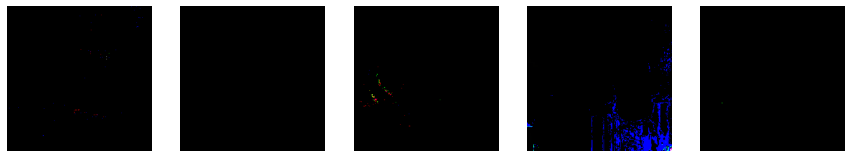

In [39]:
# Define a function to visualize images from the dataset
def visualize_images(dataset, num_images=5):
    plt.figure(figsize=(15, 10))
    for i, (img, _) in enumerate(dataset.take(5)):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img[0].numpy().astype("uint8"))  # Display the first image in the batch
        plt.axis("off")  # Turn off axis labels
    plt.show()

# Visualize the images from the dataset
visualize_images(image_dataset)


## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [40]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input#write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output#write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(inputs=new_input, outputs=hidden_layer)#build the final model using both input & output layer

In [41]:
# Get a sample image
sample_img = tf.ones((1, 299, 299, 3))  # Assuming input shape is (1, 299, 299, 3)

# Pass the sample image through the model to get the output
output = image_model(sample_img)

# Print the shape of the output tensor
print("Shape of the output tensor:", output.shape)

2024-02-28 17:57:23.291283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


Shape of the output tensor: (1, 8, 8, 2048)


In [42]:
#model Summary
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

In [43]:
# #write your code here
# # mapping each image full path including name to the function to preprocess the image

# # sorting and storing unique path in list which will be given as input 
# training_list = sorted(set(all_img_vector)) 

# # Creating a Dataset using tf.data.Dataset.from_tensor_slice
# New_Image_Data = tf.data.Dataset.from_tensor_slices(training_list)


# # Mappng preprocess_images_function across the elements of the above dataset.
# # num_parallel_calls= tf.data.AUTOTUNE is used, then the number of parallel calls is set dynamically based on available CPU.
# New_Image_Data = New_Image_Data.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


# # Keeping batch_size=64 (64 consecutive elements of this dataset is combined in a single batch).
# # We don't want to drop the last batch if it contains element less than 64.So let's set drop_remainder=False 
# New_Image_Data= New_Image_Data.batch(64,drop_remainder=False)

In [44]:
# New_Image_Data

In [45]:
# write the code to apply the feature_extraction model to your earlier created dataset which contained images & their respective paths
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [02:14<00:00,  1.06s/it]


In [46]:
batch_features.shape

TensorShape([27, 64, 2048])

In [47]:
bf.shape

TensorShape([64, 2048])

### FAQs on how to store the features:
* You can store the features using a dictionary with the path as the key and values as the feature extracted by the inception net v3 model OR
* You can store using numpy(np.save) to store the resulting vector.

## Dataset creation
1.Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42

2.Create a function which maps the image path to their feature. 

3.Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [48]:
from sklearn.model_selection import train_test_split

path_train, path_test, cap_train, cap_test = train_test_split(all_img_vector,cap_vector,test_size=0.2,random_state=42)

In [49]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(cap_train)))
print("Testing data for Captions: " + str(len(cap_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [50]:
print(path_train[:1])
print(cap_train[:1])

['data/Images/359082432_c1fd5aa2d6.jpg']
[[  3   2  12   9   2  10  18  40   7   2 144 150 111 547  47  21   6 172
    4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


In [51]:
def map_func(image, caption):
#     print("Image:", image)
    img_tensor = np.load(image.decode('utf-8')+'.npy')
    return img_tensor, caption

### FAQs on how to load the features:
* You can load the features using the dictionary created earlier OR
* You can store using numpy(np.load) to load the feature vector.

In [52]:
# # # create a builder function to create dataset which takes in the image path & captions as input
# # # This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
def gen_dataset(image, caption,batch_size = 64,buffer_size=1000):
    
    dataset = tf.data.Dataset.from_tensor_slices((image, caption))

    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
            map_func, [item1, item2], [tf.float32, tf.int32]),
            num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size).batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


In [53]:
BATCH_SIZE = 64

In [54]:

train_dataset=gen_dataset(path_train,cap_train,BATCH_SIZE)
test_dataset=gen_dataset(path_test,cap_test, BATCH_SIZE)

In [55]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 35)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [56]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words a+1
train_num_steps = len(path_train)//BATCH_SIZE #len(total train images) // BATCH_SIZE
test_num_steps = len(path_test)//BATCH_SIZE#len(total test images) // BATCH_SIZE

In [57]:
print(train_num_steps)
print(test_num_steps)

505
126


### Encoder

In [58]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        #build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim)
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
#         features = tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold = 0)
        features = tf.nn.relu(features)
        return features

In [59]:
encoder=Encoder(embedding_dim)

### Attention model

In [60]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units
    

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, axis=1)
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
        score = self.V(attention_hidden_layer)
        # Compute attention weights with shape: (batch_size, 8*8, 1)
        attention_weights = tf.nn.softmax(score, axis=1)        
        # Compute the context vector with shape: (batch_size, 8*8, embedding_dim)
        context_vector = attention_weights * features        
        # Reduce the shape to (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1)
        

        return context_vector, attention_weights

In [61]:
attention_model = Attention_model(units)

### Decoder

In [62]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(units)
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.gru = tf.keras.layers.GRU(self.units, 
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units)
        self.d2 = tf.keras.layers.Dense(vocab_size)
        

    def call(self,x,features, hidden):
        # x: input to the decoder (word indices), shape: (batch_size, 1)
        # features: output from the encoder (image features), shape: (batch_size, 8*8, embedding_dim)
        # hidden: hidden state from the previous time step, shape: (batch_size, hidden_size)
        
        # Compute context vector and attention weights
        context_vector, attention_weights = self.attention(features, hidden)
        
        # Embed the input word indices, shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        
        # Concatenate input embeddings with context vector, shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        
        # Pass the concatenated embeddings through GRU
        output, state = self.gru(embed)
        
        # Apply dense layers
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2]))  # shape: (batch_size * 1, hidden_size)
        output = self.d2(output)  # shape: (batch_size * 1, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [63]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [64]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [65]:
optimizer = tf.keras.optimizers.Adam()#define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')#define your loss object

In [66]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [67]:
train_checkpoint = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, train_checkpoint, max_to_keep=5)

In [68]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

* While creating the training step for your model, you will apply Teacher forcing.
* Teacher forcing is a technique where the target/real word is passed as the next input to the decoder instead of previous prediciton.

In [69]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        # Pass the image through the encoder
        features = encoder(img_tensor)
        
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    avg_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
        
    return loss, avg_loss

* While creating the test step for your model, you will pass your previous prediciton as the next input to the decoder.

In [70]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    # Initialize the hidden state of the decoder
    hidden = decoder.init_state(batch_size=target.shape[0])
    # Initialize the input to the decoder
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1,target.shape[1]):
            predictions,hidden,_ = decoder(dec_input,features,hidden)
            loss += loss_function(target[:,i], predictions)
            predicted_id = tf.argmax(predictions,1)
            dec_input = tf.expand_dims(predicted_id, 1)

    
    avg_loss = (loss / int(target.shape[1]))
        
    return loss, avg_loss

In [71]:
def test_loss_cal(test_dataset):
    total_loss = 0
    # Iterate over the test dataset
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        # Compute loss for the batch
        batch_loss, t_loss = test_step(img_tensor, target)
        # Aggregate batch loss
        total_loss += t_loss
    # Calculate average loss over all batches
    avg_test_loss = total_loss / test_num_steps

    return avg_test_loss

In [72]:
#Run Epochs
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  7%|▋         | 1/15 [02:20<32:51, 140.84s/it]

For epoch: 1, the train loss is 1.340, & test loss is 2.060
Time taken for 1 epoch 140.65902948379517 sec

Test loss has been reduced from 100.000 to 2.060


 13%|█▎        | 2/15 [03:08<18:41, 86.24s/it] 

For epoch: 2, the train loss is 1.042, & test loss is 2.103
Time taken for 1 epoch 48.01829981803894 sec



 20%|██        | 3/15 [03:57<13:48, 69.08s/it]

For epoch: 3, the train loss is 0.946, & test loss is 2.004
Time taken for 1 epoch 48.47158646583557 sec

Test loss has been reduced from 2.060 to 2.004


 27%|██▋       | 4/15 [04:45<11:07, 60.72s/it]

For epoch: 4, the train loss is 0.880, & test loss is 2.062
Time taken for 1 epoch 47.89203071594238 sec



 33%|███▎      | 5/15 [05:33<09:21, 56.12s/it]

For epoch: 5, the train loss is 0.826, & test loss is 2.070
Time taken for 1 epoch 47.97458481788635 sec



 40%|████      | 6/15 [06:21<08:00, 53.44s/it]

For epoch: 6, the train loss is 0.778, & test loss is 2.124
Time taken for 1 epoch 48.240140199661255 sec



 47%|████▋     | 7/15 [07:09<06:54, 51.77s/it]

For epoch: 7, the train loss is 0.734, & test loss is 2.179
Time taken for 1 epoch 48.330711126327515 sec



 53%|█████▎    | 8/15 [07:58<05:54, 50.67s/it]

For epoch: 8, the train loss is 0.694, & test loss is 2.169
Time taken for 1 epoch 48.31226134300232 sec



 60%|██████    | 9/15 [08:46<04:59, 49.91s/it]

For epoch: 9, the train loss is 0.657, & test loss is 2.247
Time taken for 1 epoch 48.238340616226196 sec



 67%|██████▋   | 10/15 [09:34<04:07, 49.42s/it]

For epoch: 10, the train loss is 0.621, & test loss is 2.315
Time taken for 1 epoch 48.31713628768921 sec



 73%|███████▎  | 11/15 [10:23<03:16, 49.09s/it]

For epoch: 11, the train loss is 0.589, & test loss is 2.408
Time taken for 1 epoch 48.32650566101074 sec



 80%|████████  | 12/15 [11:11<02:26, 48.84s/it]

For epoch: 12, the train loss is 0.558, & test loss is 2.498
Time taken for 1 epoch 48.281198501586914 sec



 87%|████████▋ | 13/15 [11:59<01:37, 48.70s/it]

For epoch: 13, the train loss is 0.530, & test loss is 2.572
Time taken for 1 epoch 48.382049322128296 sec



 93%|█████████▎| 14/15 [12:48<00:48, 48.61s/it]

For epoch: 14, the train loss is 0.503, & test loss is 2.650
Time taken for 1 epoch 48.390220403671265 sec



100%|██████████| 15/15 [13:36<00:00, 54.41s/it]

For epoch: 15, the train loss is 0.479, & test loss is 2.718
Time taken for 1 epoch 47.96573257446289 sec



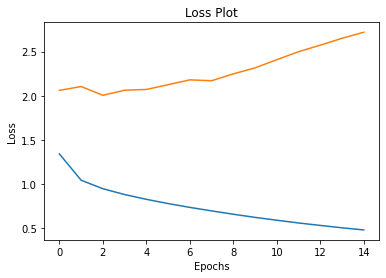

In [73]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

#### NOTE: 
* Since there is a difference between the train & test steps ( Presence of teacher forcing), you may observe that the train loss is decreasing while your test loss is not. 
* This doesn't mean that the model is overfitting, as we can't compare the train & test results here, as both approach is different.
* Also, if you want to achieve better results you can run it more epochs, but the intent of this capstone is to give you an idea on how to integrate attention mechanism with E-D architecture for images. The intent is not to create the state of art model. 

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [74]:
attention_features_shape=64
def evaluate(image):
    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input)# Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)# extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_sequence_len):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)# get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [75]:
def beam_evaluate(image, beam_index = 3):

    #write your code to evaluate the result using beam search
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_sequence_len, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(preprocess_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_sequence_len:
        temp = []
        for i, s in enumerate(result):
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            word_preds = np.argsort(predictions[0])[-beam_index:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)

                prob += np.log(predictions[0][w])

                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]


        predicted_id = result[-1]
        pred_list = predicted_id[0]

        prd_id = pred_list[-1]
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break


    result2 = result[-1][0]

    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)

        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
    return final_caption

a little is through a shopping cart


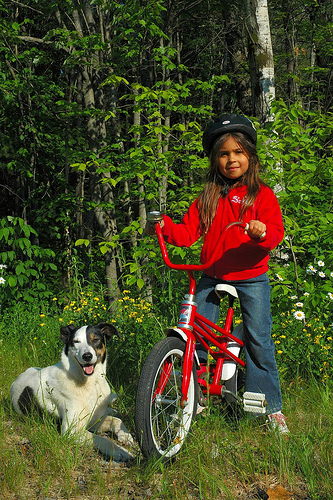

In [76]:
test_image = "./data/Images/179009558_69be522c63.jpg"


captions=beam_evaluate(test_image)
print(captions)
Image.open(test_image)

In [77]:
from PIL import Image
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [78]:
from nltk.translate.bleu_score import sentence_bleu

In [79]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [80]:
img_test=path_test.copy()

In [81]:
def predicted_caption_audio(cap_test, random,autoplay=False,weights=(0.5, 0.5, 0, 0)):

    cap_test=cap_test.copy()
    rid = np.random.randint(0, random)
    test_image = img_test[rid]
    #test_image = 'Flickr8K/Images/413231421_43833a11f5.jpg'
    #real_caption = '<start> black dog is digging in the snow <end>'

    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test[rid] if i not in [0]])
    result, attention_plot,pred_test = evaluate(test_image)

    real_caption=filt_text(real_caption)      

    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()

    score = sentence_bleu(reference, candidate, weights=weights)#set your weights)
    print(f"BELU score: {score*100}")

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attmap(result, attention_plot, test_image)

    #Google API for Text-to-speech 
    speech = gTTS("Predicted Caption is: "+ pred_caption,lang = 'en', slow = False) 
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'
    #playsound('voice.wav')
    display.display(display.Audio(audio_file, rate=None,autoplay=autoplay))
    
    return test_image

/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


BELU score: 20.2730101342321
Real Caption: a man in shorts is standing on a rock looking out at the view from the hilltop
Prediction Caption: a shirtless man jumps a rock cliff overlooking the clouds


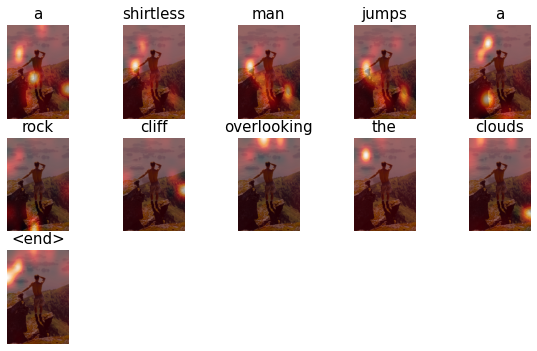

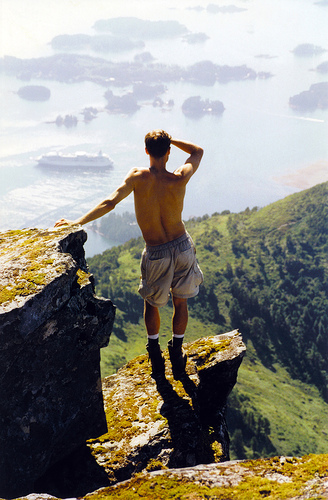

In [82]:
test_image=predicted_caption_audio(cap_test, 5,True,weights=(0.5,0.25,0,0))

Image.open(test_image)

In [83]:
def Predict_Unknown_data(test_image):
    #Testing on test image
    openImg = test_image
    result, attention_plot,pred_test = evaluate(test_image)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]

    candidate = pred_caption.split()

    print ('Prediction Caption:', pred_caption)
    print ('')
    newsize = (800, 800)
    im = Image.open(openImg).resize(newsize)
    width, height = im.size
    print(width,height)
    div=3
    if width > 3000:
        div=10
    im = im.resize((width//div, height//div))
    
    return im

Prediction Caption: a brown and white dog leaps over a fence

800 800


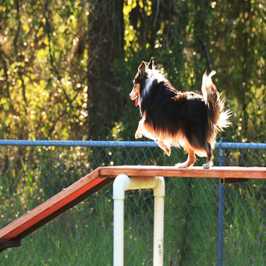

In [84]:
Predict_Unknown_data(path_test[141])